In [1]:
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.utils import to_categorical
from keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

2024-04-17 20:19:32.993168: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 20:19:32.993330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 20:19:33.150385: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data  = np.load("/kaggle/input/features-extracted-own-seed-shuffled/Shuffled/PSD/shuffled_X.npy")
labels_edited  = np.load("/kaggle/input/features-extracted-own-seed-shuffled/Shuffled/PSD/shuffled_y.npy")

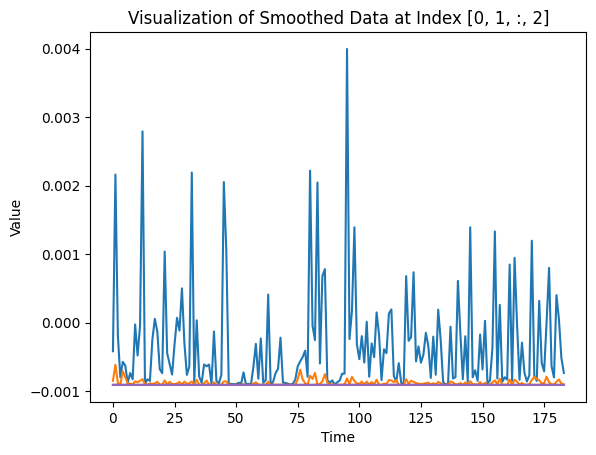

In [3]:
# Visualize the smoothed data
plt.plot(data[0, 2, :, :])
plt.title("Visualization of Smoothed Data at Index [0, 1, :, 2]")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

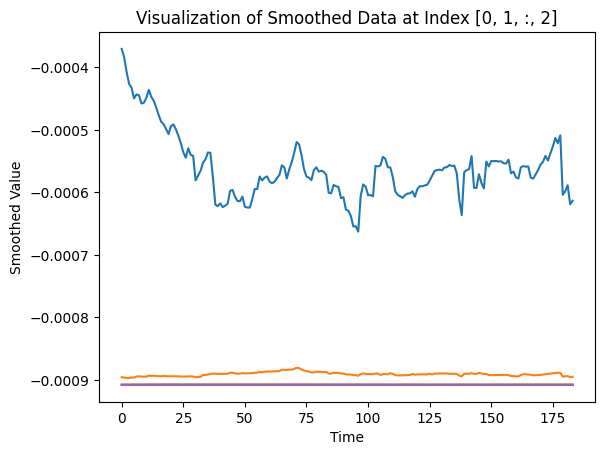

In [4]:
import pandas as pd

# Define the window size for the moving average filter
window_size = 40

# Apply the moving average filter
smoothed_data = np.zeros_like(data)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        for k in range(data.shape[3]):
            series = pd.Series(data[i, j, :, k])
            smoothed_data[i, j, :, k] = series.rolling(window=window_size, center=True, min_periods=1).mean()

# Visualize the smoothed data
plt.plot(smoothed_data[1, 2, :, :])
plt.title("Visualization of Smoothed Data at Index [0, 1, :, 2]")
plt.xlabel("Time")
plt.ylabel("Smoothed Value")
plt.show()

In [5]:
data = smoothed_data

In [6]:
max = np.max(data)
min = np.min(data)

#Normalizing data
data = data/max
data = (data - np.mean(data))/np.std(data)


#Splitting Dataset into train, validation, test 
train_labels = labels_edited[0:550]
test_labels = labels_edited[550:600]
final_labels = labels_edited[600:675]

train_data = data[0:550]
test_data = data[550:600]
final_test = data[600:675]



cf_labels = np.where(final_labels== -1, 2, final_labels) #Label in the form for confusion matrix
un, co = np.unique(cf_labels, return_counts=True)
print(f'Unique: {un}, Counts: {co}')

Unique: [0 1 2], Counts: [25 26 24]


In [7]:
# Reshape train_data to be 2D (550, 62*265*5)
train_data_flattened = train_data.reshape(train_data.shape[0], -1)

# Reshape final_test to be 2D (75, 62*265*5)
final_test_flattened = final_test.reshape(final_test.shape[0], -1)

# One-hot encode labels
num_classes = 3  # Update with the actual number of classes
train_labels_encoded = to_categorical(train_labels, num_classes=num_classes)
final_labels_encoded = to_categorical(final_labels, num_classes=num_classes)

In [8]:
# Initialize the Random Forest model with the best hyperparameters
rf_model = RandomForestClassifier(n_estimators=200,
                                       min_samples_split=2,
                                       min_samples_leaf=2,
                                       max_features='sqrt',
                                       max_depth=None,
                                       bootstrap=False)

# Train the model on the training data
rf_model.fit(train_data_flattened, np.argmax(train_labels_encoded, axis=1))

# Use the trained model for predictions on the final test data
predictions = rf_model.predict(final_test_flattened)

In [9]:
# One-hot encode predictions
predictions_encoded = to_categorical(predictions, num_classes=num_classes)

In [10]:
# Calculate accuracy
accuracy = accuracy_score(np.argmax(final_labels_encoded, axis=1), np.argmax(predictions_encoded, axis=1))
# Print accuracy
print(f"Accuracy: {accuracy:.2%}")


Accuracy: 65.33%


Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.76      0.73        25
           1       0.64      0.62      0.63        26
           2       0.61      0.58      0.60        24

   micro avg       0.65      0.65      0.65        75
   macro avg       0.65      0.65      0.65        75
weighted avg       0.65      0.65      0.65        75
 samples avg       0.65      0.65      0.65        75



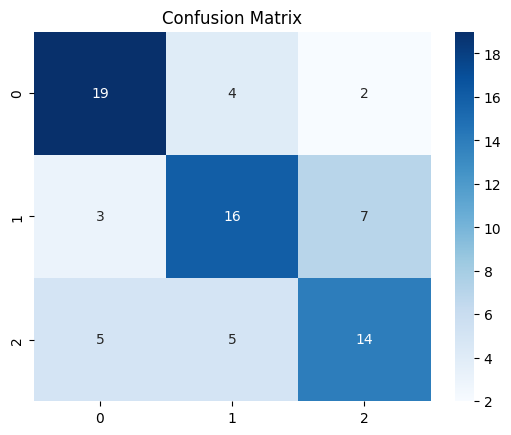

Classification Report:
               precision    recall  f1-score   support

     Neutral       0.70      0.76      0.73        25
    Positive       0.64      0.62      0.63        26
    Negative       0.61      0.58      0.60        24

    accuracy                           0.65        75
   macro avg       0.65      0.65      0.65        75
weighted avg       0.65      0.65      0.65        75



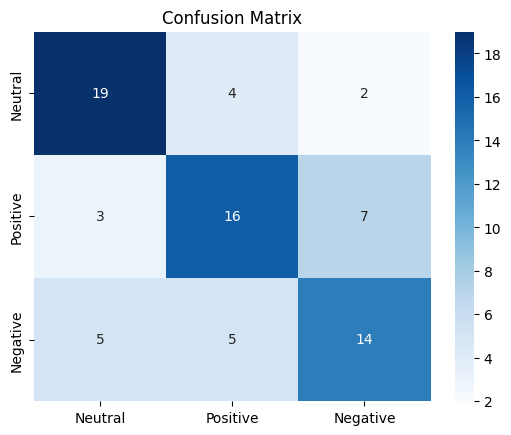

In [11]:
# Classification Report
class_report = classification_report(final_labels_encoded, predictions_encoded)
print("Classification Report:\n", class_report)


# Confusion Matrix
conf_matrix = confusion_matrix(np.argmax(final_labels_encoded, axis=1), np.argmax(predictions_encoded, axis=1))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")

plt.show()


# Replace labels in Classification Report
class_report = classification_report(np.argmax(final_labels_encoded, axis=1), np.argmax(predictions_encoded, axis=1), target_names=['Neutral', 'Positive', 'Negative'])
print("Classification Report:\n", class_report)

# Replace labels in Confusion Matrix
conf_matrix = confusion_matrix(np.argmax(final_labels_encoded, axis=1), np.argmax(predictions_encoded, axis=1))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Neutral', 'Positive', 'Negative'], yticklabels=['Neutral', 'Positive', 'Negative'])
plt.title("Confusion Matrix")

#plt.savefig(f"SVM.jpg", dpi=300)
#plt.savefig(f"SVM.pdf", dpi=300)
plt.show()

In [12]:

# Calculate accuracy
accuracy = accuracy_score(np.argmax(final_labels_encoded, axis=1), np.argmax(predictions_encoded, axis=1))
print(f"Accuracy: {accuracy:.2%}")

# Classification Report
class_report = classification_report(
    np.argmax(final_labels_encoded, axis=1), 
    np.argmax(predictions_encoded, axis=1), 
    target_names=['Neutral', 'Positive', 'Negative'],
    output_dict=True
)

# Convert to DataFrame for better manipulation
class_report_df = pd.DataFrame(class_report)
class_report_df = class_report_df.transpose()

# Convert values to percentages
class_report_df *= 100

# Append average metrics to the DataFrame
avg_metrics = pd.DataFrame(class_report_df.iloc[-1]).transpose()
class_report_df = class_report_df.drop(['accuracy', 'macro avg', 'weighted avg'])

class_report_df = pd.concat([class_report_df, avg_metrics], axis=0)

# Save the classification report as CSV
class_report_df.to_csv("classification_report.csv")

# Save the classification report as TXT
with open("classification_report.txt", "w") as text_file:
    text_file.write(classification_report(
        np.argmax(final_labels_encoded, axis=1), 
        np.argmax(predictions_encoded, axis=1), 
        target_names=['Neutral', 'Positive', 'Negative']
    ))

# Display the classification report
print("Classification Report:\n", class_report_df)

Accuracy: 65.33%
Classification Report:
               precision     recall   f1-score  support
Neutral       70.370370  76.000000  73.076923   2500.0
Positive      64.000000  61.538462  62.745098   2600.0
Negative      60.869565  58.333333  59.574468   2400.0
weighted avg  65.121718  65.333333  65.174438   7500.0


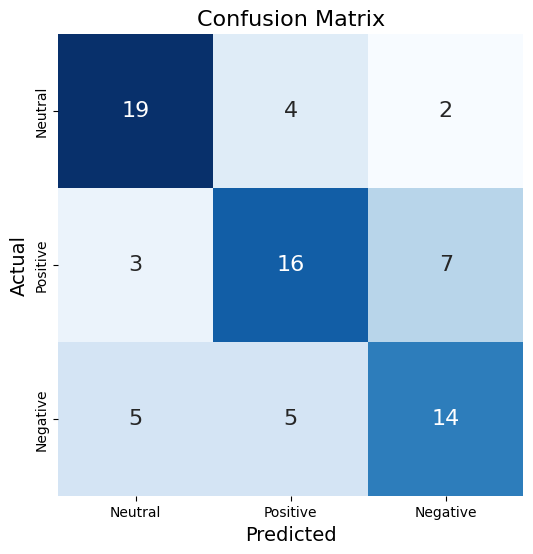

In [13]:
# Save Confusion Matrix as PDF
plt.figure(figsize=(6, 6))  # Adjust figure size as needed
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Neutral', 'Positive', 'Negative'], yticklabels=['Neutral', 'Positive', 'Negative'], cbar=False, annot_kws={"size": 16})  # Adjust the font size as needed
plt.title("Confusion Matrix", fontsize=16)  # Increase font size
plt.xlabel('Predicted', fontsize=14)  # Increase font size
plt.ylabel('Actual', fontsize=14)  # Increase font size
plt.savefig("confusion_matrix.pdf", dpi=300, bbox_inches='tight')  # Save as PDF without extra margins
plt.show()
